In [1]:
import os
import glob
import operator as op

import numpy             as np
import matplotlib.pyplot as plt

from CCutils import lmap
from CCutils import npmap
from CCfun   import in_range
from CCfun   import compute_baseline_float
from CCfun   import datetime_from_spectrum

from CCplot  import plot1d
from CCplot  import plot_line
from CCplot  import auto_plot_style
from CCplot  import figure_sizes
from CCplot  import subplots

from CCfit   import shifted_gauss
from CCfit   import shifted_expo
from CCfit   import fit

from CCio    import load_ccd_file

In [2]:
maindir = "/home/gonzalo/data/CC/position_dependence//"

auto_plot_style({"lines.markersize" : 10})

In [3]:
def orderer(filename):
    basename = filename.split("/")[-1]
    tokens   = basename.split("_")
    index    = 0
    for token in tokens:
        if token[0].isdigit():
            index = 100 * index + int(token)
    return index

def find_max(x, y):
    m  = in_range(x, 600, 900)
    return y[m].max()

def sum_(x, y):
    m  = in_range(x, 600, 900)
    return y[m].sum()

def integrate(emwl, spectrum, rebin_by=1):
    x  = emwl
    y  = spectrum
    y -= compute_baseline_float(y)
    if rebin_by > 1:
        x = rebin(x, rebin_by, np.mean)
        y = rebin(y, rebin_by, np.sum )
    
    y  = y[x > 630]
    x  = x[x > 630]
    
    s  = find_max(x, y), 770,  30,  0
    f  = fit(shifted_gauss, x, y, s, fit_range = (600, 1150), maxfev=int(1e6))
    #plt.figure()
    #plt.plot(x, y, "k.")
    #plt.plot(x, f.fn(x), "b-")
    return f.values[0] * np.diff(x)[0]

def fit_selfbleach(x, y):
    s  = 1e9, -50, 5e9
    f  = fit(shifted_expo, x, y, s, maxfev=int(1e6))
    plt.scatter(x, y)
    plt.plot(x, f.fn(x), "y-")
    return f.values[0], -f.values[1], f.values[2]

# Different positions in the wheel

In [4]:
filenames = sorted(glob.glob(os.path.join(maindir, "*signal*")), key=orderer)
datas     =  lmap(load_ccd_file, filenames)
em_wls    =  lmap(op.attrgetter("em_wl"), datas)
times     = npmap(datetime_from_spectrum, datas)
times     = npmap(op.attrgetter("seconds"), times - times[0]) * 1.0
spectra   = [s.rate / s.power.mean for s in datas]
peaks     = npmap(sum_, em_wls, spectra)
integrals = npmap(integrate, em_wls, spectra)

[1.         1.18393101 1.17384625 1.00439953 1.03398552 1.0804294
 1.06398265 1.04780595]


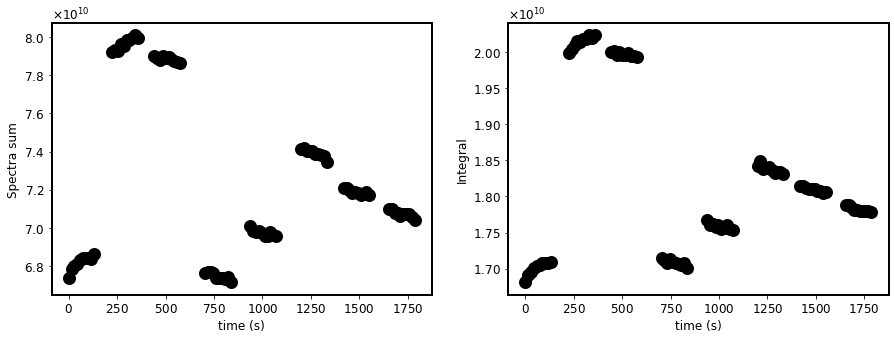

In [15]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(times, peaks)
plt.xlabel("time (s)")
plt.ylabel("Spectra sum")


plt.subplot(1, 2, 2)
plt.scatter(times, integrals)
plt.xlabel("time (s)")
plt.ylabel("Integral")

means = np.reshape(integrals, (8, len(integrals)//8)).mean(axis=1)
print(means / means[0])